# PiB Data : 1st and 2nd order models [WIP]

* using [GP](https://gpytorch.ai/) (differentiable with PyTorch=1.3), **can improve initialization of loglikelihood object**
* Draft for *quick* experiments prototyping

In [1]:
import os, sys
import sys

# Setting paths to directory roots | >> hgn_reproduce
parent = os.path.dirname(os.path.dirname(os.path.abspath('')))
print(parent)
sys.path.insert(0, parent)
os.chdir(parent)
print('Setting root path to : {}'.format(parent))

# Generic
import math
import argparse
import datetime
import json
from tqdm import tqdm
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from scipy.integrate import solve_ivp
from scipy.stats import ranksums

# Torch
import torch
import torch.utils.data as data_utils
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# utils
import gpytorch
import torchdiffeq
from src.utils.op import gpu_numpy_detach
from src.utils.datasets import get_fromdataframe
from src.utils.models import ExactGPModel, Christoffel, Hamiltonian
from src.utils.integrators import torchdiffeq_torch_integrator

/Users/paul.vernhet/PhD_Aramis/experiments/local/PiB_analysis
Setting root path to : /Users/paul.vernhet/PhD_Aramis/experiments/local/PiB_analysis


Global variables + read data and extract corresponding dataframe, save it if necessary

In [2]:
data_dir = '/Users/paul.vernhet/PhD_Aramis/experiments/data/ode_data/wrap_summer2019'
min_visits = 3
pib_threshold = 1.2
var_data = 0.07**2
seed = 666
batch_size = 16
standardize = True

def get_dataframe(data_path, min_visits):
    """
    :param data_path: absolute path to data
    :return: dataframe with columns (time (list) | values (list) | apoe_all1 (int) | apoe_all2 (int))
    """
    # Get data (as pandas dataframes)
    df_pib = pd.read_sas(os.path.join(data_path, 'pib.sas7bdat'), format='sas7bdat')
    # df_mri = pd.read_sas(os.path.join(data_path, 'mri.sas7bdat'), format='sas7bdat')
    df_demo = pd.read_sas(os.path.join(data_path, 'demo.sas7bdat'), format='sas7bdat')
    # df_pacc = pd.read_sas(os.path.join(data_path, 'pacc.sas7bdat'), format='sas7bdat')

    # Preprocess data
    df_demo['reggieid'] = df_demo.reggieid.astype(int)
    df_pib['reggieid'] = df_pib.reggieid.astype(int)
    df_pib.head()
    df_time = df_pib.groupby(['reggieid'])['pib_age'].apply(list)
    df_values = df_pib.groupby(['reggieid'])['pib_index'].apply(list)
    df_merged = pd.concat([df_time, df_values], axis=1)
    assert len(df_time) == len(df_values) == len(df_merged)
    print('Number of patients : {:d}'.format(len(df_merged)))
    df_merged = df_merged[df_merged['pib_age'].apply(lambda x: len(x)) >= min_visits]
    print('Number of patients with visits > {} time : {:d}'.format(min_visits - 1, len(df_merged)))

    # Final merge
    df = df_merged.join(df_demo.set_index('reggieid')[['apoe_all1', 'apoe_all2']])
    return df

Generate data, viz training sequences :

Number of patients : 231
Number of patients with visits > 2 time : 113
Train : 79 | Validation 11 | Test 23


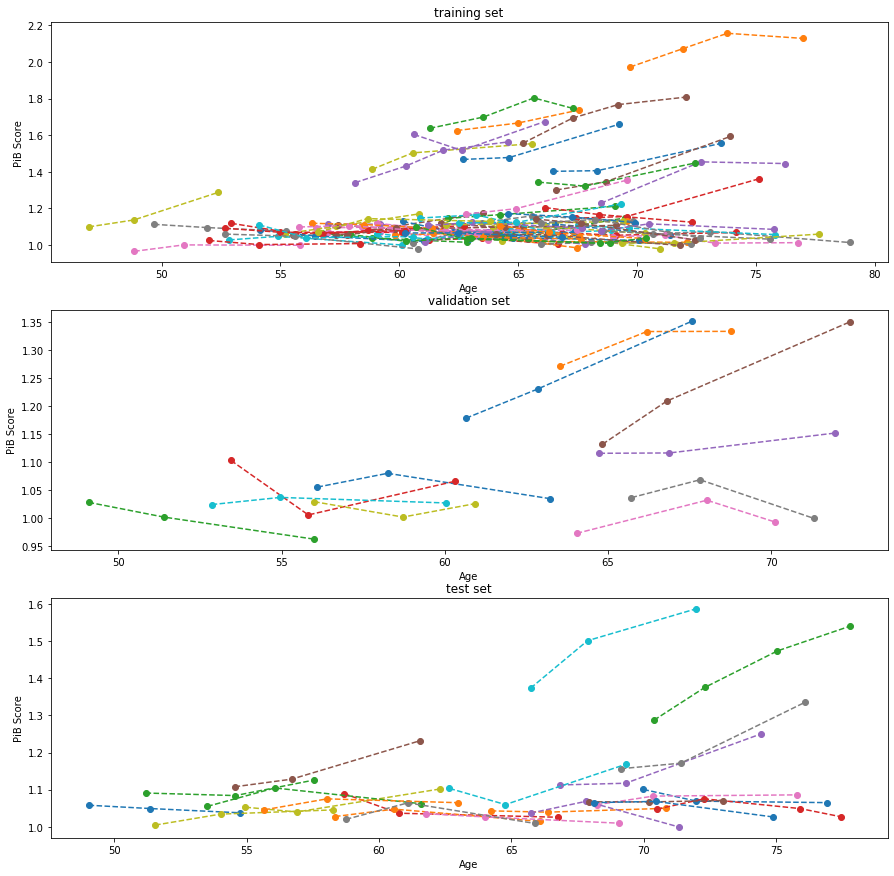

In [3]:
# -------- DATA GENERATION
df = get_dataframe(data_path=data_dir, min_visits=min_visits)
train_loader, val_loader, test_loader, all_loader, (times_mean, times_std), (data_mean, data_std) = get_fromdataframe(df=df, batch_size=batch_size, 
                                                                                                                      standardize=standardize, seed=seed)
destandardize_time = lambda time: time * times_std + times_mean if standardize else time
destandardize_data = lambda data: data * data_std + data_mean if standardize else data
destandardize_d1 = lambda der: der * data_std / times_std if standardize else data
totorch = lambda data, form: torch.from_numpy(data).float().view(-1, 1) if form == 'float' else torch.from_numpy(data).double().view(-1, 1)

# -------- VIZ
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
for i, (data_loader, name) in enumerate(zip([train_loader, val_loader, test_loader], ['training', 'validation', 'test'])):
    ax[i].set_title('{} set'.format(name))
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('PiB Score')
    for batch_idx, (positions, maskers, times, sequences, _) in enumerate(data_loader):
        for position, masker, time, sequence in zip(positions, maskers, times, sequences):
            t = gpu_numpy_detach(destandardize_time(time[masker == True]))
            s = gpu_numpy_detach(destandardize_data(sequence[masker == True]))
            ax[i].plot(t, s, '--o')
plt.show()

### A. Quadratic regression + polynomial regression for second order with Christoffel symbols : 

---
Original nb points : 113 
Retained nb points : 79
---



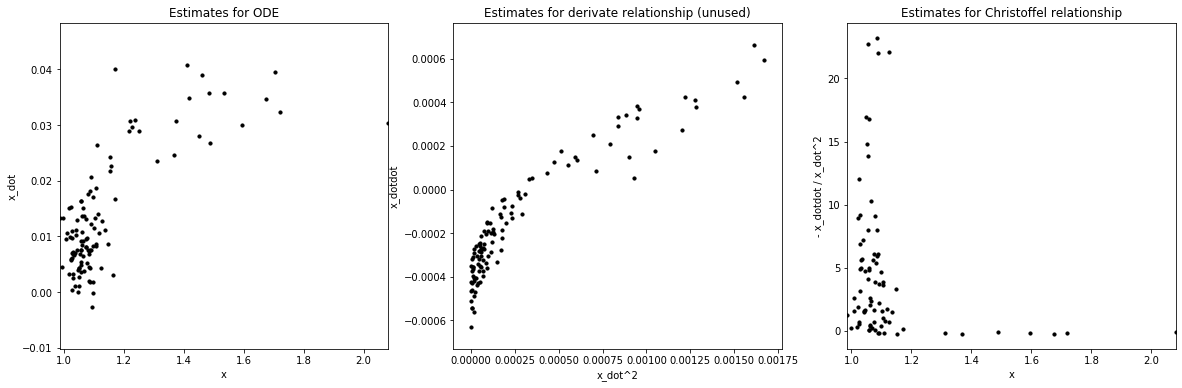

In [4]:
# ------ PERFORM REGRESSION
polynomial_features = PolynomialFeatures(degree=2,  include_bias=True)
alpha_ridge = 1e-10 if standardize else 1e1
ridge_regression = Ridge(alpha=alpha_ridge, fit_intercept=False)
which_regression = 'ridge'
assert which_regression in ['ridge', 'sigmoid']
x_real = []
t_real = []
stats_derivatives = {'t_bar':[], 'means':[], 'bias':[], 'covars':[]}


for batch_idx, (positions, maskers, times, sequences, _) in enumerate(all_loader):
    for position, masker, time, sequence in zip(positions, maskers, times, sequences):
        
        # ------ Read STANDARDIZED data (as Ridge regression is not scale invariant)
        t = gpu_numpy_detach(time[masker == True])
        s = gpu_numpy_detach(sequence[masker == True])
        n = len(t)
        assert n > 2, "At least 3 points required for a 2nd order derivative estimate"
        t_bar = np.mean(t)
        
        if which_regression == 'ridge':
            # ------ Ridge Regression
            # i) Fit Ridge regression
            t_poly = polynomial_features.fit_transform(t.reshape(-1, 1))
            ridge_regression.fit(t_poly, s)
            theta = np.array(ridge_regression.coef_)
            A_func = lambda t_ref: np.array([[1, t_ref, t_ref**2], [0., 1., 2*t_ref], [0., 0., 2]])
            A_bar = A_func(t_bar)

            # ii) Regress fitted data at mean time point (ie t_bar)
            s_hat = A_bar.dot(theta)

            # iii) Store bias and variances on (biased) estimator
            H = np.linalg.inv(np.transpose(t_poly).dot(t_poly) + alpha_ridge*n*np.eye(3)).dot(np.transpose(t_poly).dot(t_poly))
            bias_theta = H.dot(theta)
            covar_theta = var_data*H.dot(np.linalg.inv(np.transpose(t_poly).dot(t_poly) + alpha_ridge*n*np.eye(3)))
            bias_derivatives = A_bar.dot(bias_theta)
            covars_derivatives = A_bar.dot(covar_theta).dot(np.transpose(A_bar))   
        else:
            # ------ Sigmoid Regression under isotonic constraint (c > 0)
            # i) Fit logistic regression by OLS
            def np_sigmoid(x, *p):
                x0, y0, c = p
                return c / (1 + np.exp(-(x-x0))) + y0
            
            def np_velocity_sigmoid(x, *p):
                x0, y0, c = p
                sigma = np_sigmoid(x, *p)
                return 1. / c * (sigma - y0) * (c + y0 - sigma)
            
            def np_acceleration_sigmoid(x, *p):
                x0, y0, c = p
                sigma = np_sigmoid(x, *p)
                return (1. / c) ** 2 * (sigma - y0) * (c + y0 - sigma) * (c + 2 * y0 - 2 * sigma)
            
            p_guess = np.array([np.median(t), np.median(s), 1.0])
            eps = 1e-3
            p_star, p_cov = curve_fit(f=np_sigmoid, xdata=t, ydata=s, p0=p_guess, bounds=([np.min(t), np.min(s), eps], [np.max(t), np.max(s), np.inf] ))
            
            s_0 = np_sigmoid(t_bar, *p_star)
            s_1 = np_velocity_sigmoid(t_bar, *p_star)
            s_2 = np_acceleration_sigmoid(t_bar, *p_star)

            # ii) Regress fitted data at mean time point (ie t_bar) --> second derivative follows sigmoid relationship
            s_hat = np.array([s_0, s_1, s_2])

            # iii) Bias and variances taken to be None here
            bias_derivatives = None
            covars_derivatives = None
            
        t_real.append(t)
        x_real.append(s)
        stats_derivatives['t_bar'].append(t_bar)
        stats_derivatives['means'].append(s_hat)
        stats_derivatives['bias'].append(bias_derivatives)
        stats_derivatives['covars'].append(covars_derivatives)

x_derivatives = np.transpose(np.stack(stats_derivatives['means']))

# ------ Plot regressions

def ax_ellipses(x_pos, y_pos, covar, ax, only_diag=False, scale=1., facecolor='none', **kwargs):
    if only_diag:
        eigenval = np.diagonal(covar)
        eigenvec = np.eye(covar.shape[0])
    else:
        eigenval, eigenvec = np.linalg.eigh(covar)
    ellipse = Ellipse((0, 0),
        width=eigenval[0],
        height=eigenval[1],
        facecolor=facecolor,
        **kwargs)
    transf = transforms.Affine2D().rotate_deg(180. / np.pi * np.arctan(eigenvec[0, 1] / eigenvec[0, 0])).scale(scale, scale).translate(x_pos, y_pos)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Gather informative data | filter out outliers
u = x_derivatives[0]
v = x_derivatives[1]
v_squ = x_derivatives[1]**2
w = x_derivatives[2]
ratio = -1. * w / v_squ        # directly proportional to Christoffel symbol
filter_quantiles = True
eps_filter = .15
if filter_quantiles:
    filtered_index = np.where((ratio > np.quantile(ratio, eps_filter)) & (ratio < np.quantile(ratio, 1 - eps_filter)))
    filtered_u = u[filtered_index]
    filtered_ratio = ratio[filtered_index]
    print('---\nOriginal nb points : {} \nRetained nb points : {}\n---\n'.format(len(ratio), len(filtered_ratio)))
else:
    filtered_index = np.arange(len(ratio))
    filtered_u = u
    filtered_ratio = ratio
    print('---\nNo filtering of extremal values\n---\n')

# Plot figures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(x=u, y=v, marker='o', color='k', s=10.) 
#for ui, vi, covi in zip(u, v, stats_derivatives['covars']):
#    ax_ellipses(ui, vi, covi[:2,:2], ax=ax1, only_diag=True, scale=1., facecolor='green', edgecolor='red', alpha=0.3)
ax1.set_xlim(np.min(u) - 1e-4, np.max(u) + 1e-4)
ax1.set_xlabel('x')
ax1.set_ylabel('x_dot')
ax1.set_title('Estimates for ODE')

ax2.scatter(x=v_squ, y=w, marker='o', color='k', s=10.)
#for ui, vi, covi in zip(v_squ, w, stats_derivatives['covars']):
#    ax_ellipses(ui, vi, covi[1:,1:], ax=ax2, only_diag=True, scale=1., facecolor='green', edgecolor='red', alpha=0.3)
ax2.set_xlim(np.min(v_squ) - 1e-4, np.max(v_squ) + 1e-4)
ax2.set_ylim(np.min(w) - 1e-4, np.max(w) + 1e-4)
ax2.set_xlabel('x_dot^2')
ax2.set_ylabel('x_dotdot')
ax2.set_title('Estimates for derivate relationship (unused)')

ax3.scatter(x=filtered_u, y=filtered_ratio, marker='o', color='k', s=10.)
ax3.set_xlim(np.min(u) - 1e-4, np.max(u) + 1e-4)
# ax3.set_ylim(np.min(ratio) - 1e-4, np.max(ratio) + 1e-4)
ax3.set_xlabel('x')
ax3.set_ylabel('- x_dotdot / x_dot^2')
ax3.set_title('Estimates for Christoffel relationship')

plt.gray()
plt.show()

Now perform GP regressions for each model : 
- for ODE model $\dot{x}=f(x)$                 
- for explicit geodesic model $\ddot{x} + \Gamma(x)\dot{x}^{2} = 0$

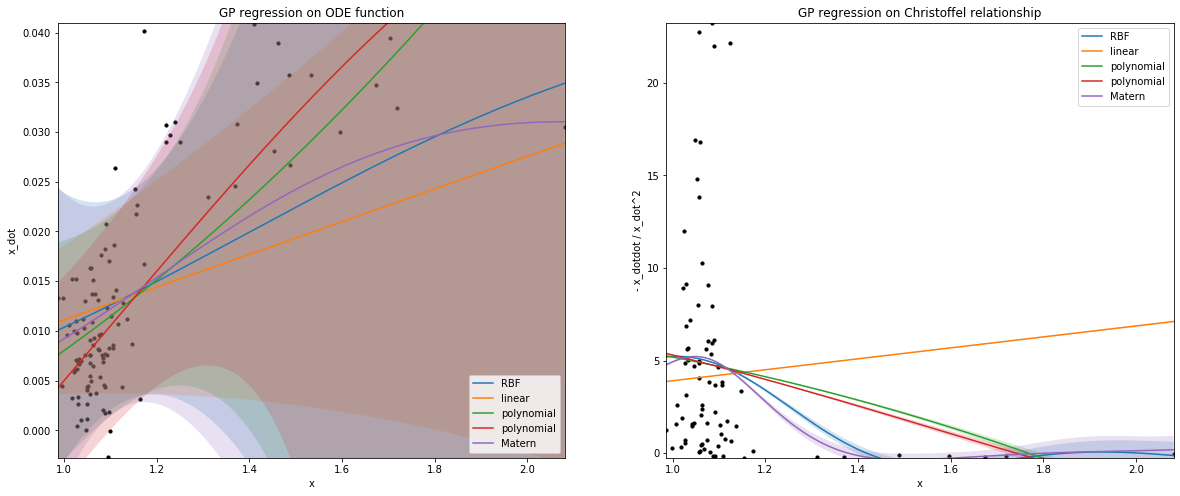

In [5]:
# ------ Gaussian Process Regression on ODE 
# GP regression (with pre-tuning of hyperparameters --> could be replaced by variance estimates computed from initial regression)
training_iter = 20
do_tuning = True
print_tuning = False
train_x = torch.from_numpy(u).float()
train_y = torch.from_numpy(v).float()
likelihood_GP = gpytorch.likelihoods.GaussianLikelihood()

# list of ODE GP models
modelGP_ODE_RBF = ExactGPModel('RBF', train_x, train_y, likelihood_GP)
modelGP_ODE_linear = ExactGPModel('linear', train_x, train_y, likelihood_GP)
modelGP_ODE_poly2 = ExactGPModel('polynomial', train_x, train_y, likelihood_GP, power=2)
modelGP_ODE_poly3 = ExactGPModel('polynomial', train_x, train_y, likelihood_GP, power=3)
modelGP_ODE_Matern = ExactGPModel('Matern', train_x, train_y, likelihood_GP, nu=2.5)

# Find optimal model hyperparameters - akin to tuning
if do_tuning:
    for model_GP in [modelGP_ODE_RBF, modelGP_ODE_linear, modelGP_ODE_poly2, modelGP_ODE_poly3, modelGP_ODE_Matern]:
        
        model_GP.train()
        likelihood_GP.train()
        optimizer = torch.optim.Adam([
            {'params': model_GP.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_GP, model_GP) # "Loss" for GPs - the marginal log likelihood

        for i in range(training_iter):

            optimizer.zero_grad()         # Zero gradients from previous iteration
            output = model_GP(train_x)       # Output from model
            loss = -mll(output, train_y)  # Calc loss and backprop gradients
            loss.backward()
            if print_tuning:
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    model_GP.covar_module.base_kernel.lengthscale.item(),
                    model_GP.likelihood.noise.item()
                ))
            optimizer.step()
        
        model_GP.eval()
        likelihood_GP.eval()

        
# ------ Gaussian Process Regression on Christoffel coefficient

train_x = torch.from_numpy(filtered_u).float()
train_y = torch.from_numpy(filtered_ratio).float()

# list of Hamiltonian GP models
modelGP_HAM_RBF = ExactGPModel('RBF', train_x, train_y, likelihood_GP)
modelGP_HAM_linear = ExactGPModel('linear', train_x, train_y, likelihood_GP)
modelGP_HAM_poly2 = ExactGPModel('polynomial', train_x, train_y, likelihood_GP, power=2)
modelGP_HAM_poly3 = ExactGPModel('polynomial', train_x, train_y, likelihood_GP, power=3)
modelGP_HAM_Matern = ExactGPModel('Matern', train_x, train_y, likelihood_GP, nu=2.5)

# Find optimal model hyperparameters - akin to tuning
if do_tuning:
    for model_GP in [modelGP_HAM_RBF, modelGP_HAM_linear, modelGP_HAM_poly2, modelGP_HAM_poly3, modelGP_HAM_Matern]:
        
        model_GP.train()
        likelihood_GP.train()
        optimizer = torch.optim.Adam([
            {'params': model_GP.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_GP, model_GP) # "Loss" for GPs - the marginal log likelihood

        for i in range(training_iter):

            optimizer.zero_grad()         # Zero gradients from previous iteration
            output = model_GP(train_x)       # Output from model
            loss = -mll(output, train_y)  # Calc loss and backprop gradients
            loss.backward()
            if print_tuning:
                print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                    i + 1, training_iter, loss.item(),
                    model_GP.covar_module.base_kernel.lengthscale.item(),
                    model_GP.likelihood.noise.item()
                ))
            optimizer.step()
        
        model_GP.eval()
        likelihood_GP.eval()
        
        
# ------ Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.scatter(x=u, y=v, marker='o', color='k', s=10.)
with torch.no_grad():
    for model_GP in [modelGP_ODE_RBF, modelGP_ODE_linear, modelGP_ODE_poly2, modelGP_ODE_poly3, modelGP_ODE_Matern]:
        u_line = np.linspace(u.min(), u.max(), 200)
        f_preds = model_GP(torch.from_numpy(u_line).float())
        f_mean = f_preds.mean
        f_var = f_preds.variance
        ax1.plot(u_line, gpu_numpy_detach(f_mean), label=model_GP.name)
        lower, upper = f_mean - 2. * f_var, f_mean + 2. * f_var
        ax1.fill_between(u_line, gpu_numpy_detach(lower), gpu_numpy_detach(upper), alpha=0.2)
ax1.set_xlim(np.min(u) - 1e-4, np.max(u) + 1e-4)
ax1.set_ylim(np.min(v) - 1e-4, np.max(v) + 1e-4)
ax1.set_xlabel('x')
ax1.set_ylabel('x_dot')
ax1.set_title('GP regression on ODE function')
ax1.legend()

ax2.scatter(x=filtered_u, y=filtered_ratio, marker='o', color='k', s=10.)
with torch.no_grad():
    for model_GP in [modelGP_HAM_RBF, modelGP_HAM_linear, modelGP_HAM_poly2, modelGP_HAM_poly3, modelGP_HAM_Matern]:
        u_line = np.linspace(u.min(), u.max(), 200)
        f_preds = model_GP(torch.from_numpy(u_line).float())
        f_mean = f_preds.mean
        f_var = f_preds.variance
        ax2.plot(u_line, gpu_numpy_detach(f_mean), label=model_GP.name)
        lower, upper = f_mean - 2. * f_var, f_mean + 2. * f_var
        ax2.fill_between(u_line, gpu_numpy_detach(lower), gpu_numpy_detach(upper), alpha=0.2)
ax2.set_xlim(np.min(filtered_u) - 1e-4, np.max(filtered_u) + 1e-4)
ax2.set_ylim(np.min(filtered_ratio) - 1e-4, np.max(filtered_ratio) + 1e-4)
ax2.set_xlabel('x')
ax2.set_ylabel('- x_dotdot / x_dot^2')
ax2.set_title('GP regression on Christoffel relationship')
ax2.legend()

plt.gray()
plt.show()

Last steps for **ODE** study : 
- rconstruct characteristic trajectory $x_{ref}(t)$
- define reference crossing time $\tau_{ODE}$ and align others with it
- compute statistics on $\tau_{ODE}$ vs $x_{t_{REF}}$ vs $APOE$

>> Rejected rate = 0.0% (0 / 113)



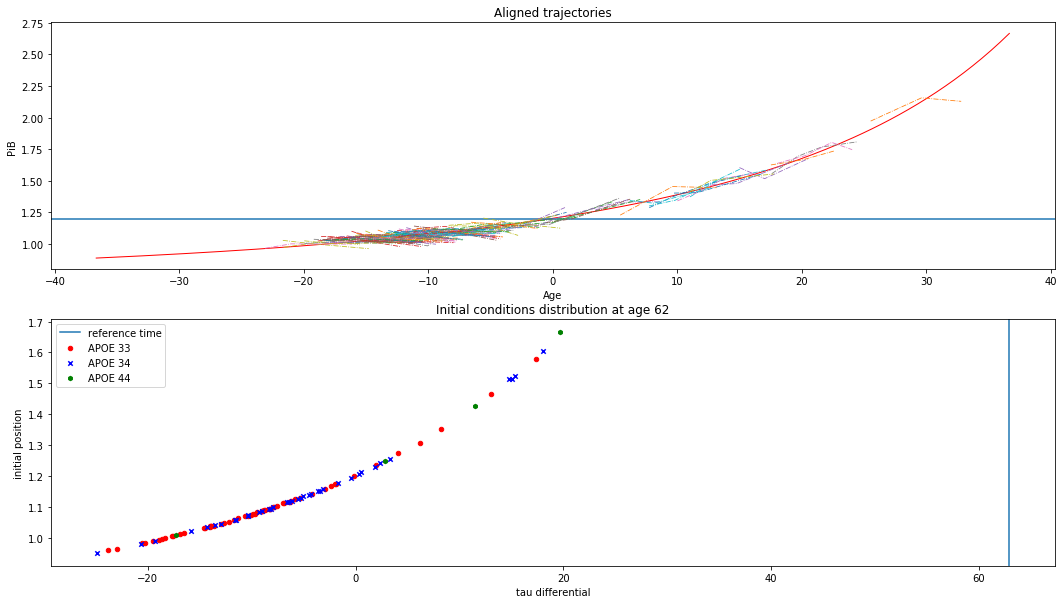

In [6]:
# ------ Reference trajectory integration
best_ODE_GP = modelGP_ODE_poly2       # modelGP_ODE_RBF | modelGP_ODE_poly2

nb_pts = 200
t_obs_var = np.concatenate(t_real).ravel().var()
t_line = np.linspace(np.concatenate(t_real).ravel().min() - .5*t_obs_var, np.concatenate(t_real).ravel().max() + .5*t_obs_var, nb_pts)
x_line = np.linspace(np.concatenate(x_real).ravel().min(), np.concatenate(x_real).ravel().max(), nb_pts)
t_ref = np.mean(t_line)
pib_threshold =(1.2 - data_mean)/ data_std if standardize else 1.2
i_start = np.argmin(np.abs(t_line-t_ref))
x_init = np.array([pib_threshold])

# slightly modifier ivp integrator 
def ivp_integrate_GP(model, t_eval, y0):
    likelihood_GP = gpytorch.likelihoods.GaussianLikelihood()
    def modelGP_numpy_integrator(t, np_x):
        x = torch.from_numpy(np_x).float()
        x = x.view(1, np.size(np_x))    # batch size of 1
        x.requires_grad = True
        # dx = likelihood_GP(model(x)).mean
        dx = model(x).mean
        return gpu_numpy_detach(dx)
    sequence = solve_ivp(fun=modelGP_numpy_integrator, t_span=(t_eval[0], t_eval[-1]), y0=y0, t_eval=t_eval, rtol=1e-10)
    return sequence['y']

forward_x = ivp_integrate_GP(model=best_ODE_GP, t_eval=t_line[i_start:], y0=x_init)
backward_x = ivp_integrate_GP(model=best_ODE_GP, t_eval=t_line[:i_start+1][::-1], y0=x_init)
reference_trajectory = np.concatenate([np.concatenate(backward_x).ravel()[::-1][:-1], np.concatenate(forward_x).ravel()])

# ------ Alignment of trajectories via tau parameter | also include APOE information if available (from start, in additional column)
labeler_func = lambda arr: int(np.sum(arr))
y_lab = []
initial_conditions = []
initial_dtau = []
time_values = []
data_values = []
rejected_values = []
i_undone = 0
i_total = 0
for batch_idx, (positions, maskers, times, sequences, labels) in enumerate(all_loader):
    for position, masker, time, sequence, label in zip(positions, maskers, times, sequences, labels):
        # ------ REDO PROCESSING STEP IN THE SAME FASHION
        t = gpu_numpy_detach(time[masker == True])
        s = gpu_numpy_detach(sequence[masker == True])
        n = len(t)
        assert n > 2, "At least 3 points required for a 2nd order derivative estimate"
        t_bar = np.mean(t)
        
        if which_regression == 'ridge':
            # ------ Ridge Regression
            # i) Fit Ridge regression
            t_poly = polynomial_features.fit_transform(t.reshape(-1, 1))
            ridge_regression.fit(t_poly, s)
            theta = np.array(ridge_regression.coef_)
            A_func = lambda t_ref: np.array([[1, t_ref, t_ref**2], [0., 1., 2*t_ref], [0., 0., 2]])
            A_bar = A_func(t_bar)

            # ii) Regress fitted data at mean time point (ie t_bar)
            s_hat = A_bar.dot(theta)  
        else:
            # ------ Sigmoid Regression under isotonic constraint (c > 0)
            # i) Fit logistic regression by OLS
            def np_sigmoid(x, *p):
                x0, y0, c = p
                return c / (1 + np.exp(-(x-x0))) + y0
            
            def np_velocity_sigmoid(x, *p):
                x0, y0, c = p
                sigma = np_sigmoid(x, *p)
                return 1. / c * (sigma - y0) * (c + y0 - sigma)
            
            def np_acceleration_sigmoid(x, *p):
                x0, y0, c = p
                sigma = np_sigmoid(x, *p)
                return (1. / c) ** 2 * (sigma - y0) * (c + y0 - sigma) * (c + 2 * y0 - 2 * sigma)
            
            p_guess = np.array([np.median(t), np.median(s), 1.0])
            eps = 1e-3
            p_star, p_cov = curve_fit(f=np_sigmoid, xdata=t, ydata=s, p0=p_guess, bounds=([np.min(t), np.min(s), eps], [np.max(t), np.max(s), np.inf] ))
            
            s_0 = np_sigmoid(t_bar, *p_star)
            s_1 = np_velocity_sigmoid(t_bar, *p_star)
            s_2 = np_acceleration_sigmoid(t_bar, *p_star)

            # ii) Regress fitted data at mean time point (ie t_bar) --> second derivative follows sigmoid relationship
            s_hat = np.array([s_0, s_1, s_2])
        
        # ------ Registration of curves by time translation wrt observed point
        i_relative = np.argmin(np.abs(reference_trajectory-s_hat[0]))
        if 0 < i_relative < len(reference_trajectory):
            tau_relative = t_line[i_relative] - t_bar
            initial_dtau.append(tau_relative)
            i_ic = np.argmin(np.abs(t_line - (t_ref + tau_relative)))
            initial_conditions.append(reference_trajectory[i_ic])
            time_values.append(t)
            data_values.append(s)
            y_lab.append(labeler_func(gpu_numpy_detach(label)))
        else:
            rejected_values.append(s_hat[0])
            i_undone += 1
        i_total += 1
print('>> Rejected rate = {:.1f}% ({} / {})\n'.format(100 * (i_undone / float(i_total)), i_undone, i_total))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(destandardize_time(torch.from_numpy(t_line - t_ref)), destandardize_data(torch.from_numpy(reference_trajectory)), '-', c='r', linewidth=1., label='reference trajectory')
ax1.axhline(y=1.2, label='reference threshold')
for data, time, tau in zip(data_values, time_values, initial_dtau):
    ax1.plot(destandardize_time(torch.from_numpy(time + tau - t_ref)), destandardize_data(torch.from_numpy(data)), '-.', linewidth=.8)
ax1.set_xlabel('Age')
ax1.set_ylabel('PiB')
ax1.set_title('Aligned trajectories')

idx_33 = np.argwhere(np.array(y_lab) == 6)
idx_34 = np.argwhere(np.array(y_lab) == 7)
idx_44 = np.argwhere(np.array(y_lab) == 8)
ax2.scatter(x=destandardize_time(torch.from_numpy(np.array(initial_dtau)[idx_33])), y=np.array(initial_conditions)[idx_33], marker='o', color='r', s=20., label='APOE 33')
ax2.scatter(x=destandardize_time(torch.from_numpy(np.array(initial_dtau)[idx_34])), y=np.array(initial_conditions)[idx_34], marker='x', color='b', s=20., label='APOE 34')
ax2.scatter(x=destandardize_time(torch.from_numpy(np.array(initial_dtau)[idx_44])), y=np.array(initial_conditions)[idx_44], marker='h', color='g', s=20., label='APOE 44')
ax2.axvline(x=destandardize_time(torch.from_numpy(np.array(t_ref))), label='reference time')
ax2.set_xlabel('tau differential')
ax2.set_ylabel('initial position')
ax2.set_title('Initial conditions distribution at age {:d}'.format(int(destandardize_time(torch.from_numpy(np.array(t_ref))))))
ax2.legend()

plt.show()

**Wilcoxon** statistical [test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html) on APOE populations :

APOE 33
          age at PiB positive :     72.11 +- 8.08
          PiB at reference age 62 : 1.10 +- 0.11
APOE 34
          age at PiB positive :     68.00 +- 9.47
          PiB at reference age 62 : 1.16 +- 0.15
APOE 44
          age at PiB positive :     58.75 +- 13.76
          PiB at reference age 62 : 1.34 +- 0.24


Wilcoxon test p-value for difference in age at PIB positive between APOE 33 and APOE 34 = 0.015
Wilcoxon test p-value for difference in PIB (at ref age) between APOE 33 and APOE 34 = 0.014
-----
Wilcoxon test p-value for difference in age at PIB positive between APOE 33 and APOE 44 = 0.081
Wilcoxon test p-value for difference in PIB (at ref age) between APOE 33 and APOE 44 = 0.081
-----
Wilcoxon test p-value for difference in age at PIB positive between APOE 34 and APOE 44 = 0.170
Wilcoxon test p-value for difference in PIB (at ref age) between APOE 34 and APOE 44 = 0.170




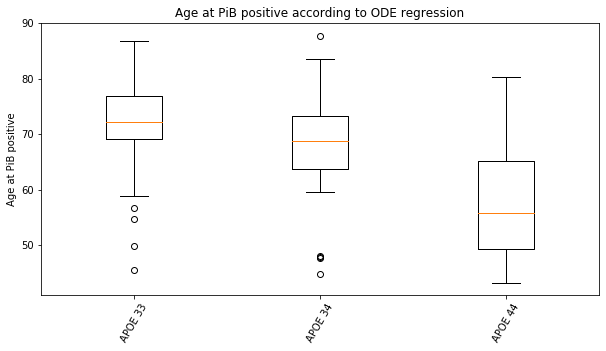

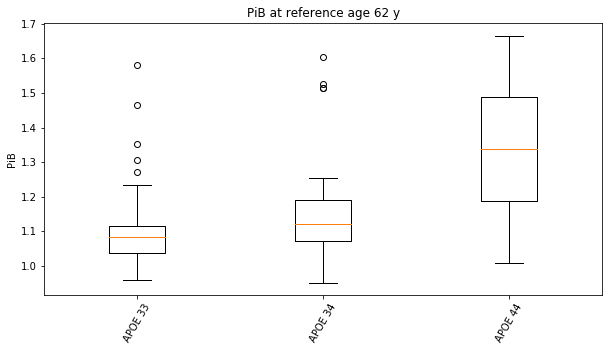

In [7]:
# -------- randomly draw pairs between labels
boxplot_stock = []
boxplot_stock2 = []
for ic, name in zip([idx_33, idx_34, idx_44], ['APOE 33', 'APOE 34', 'APOE 44']):
    age_tref = int(gpu_numpy_detach(destandardize_time(torch.from_numpy(np.array([t_ref]))))[0])
    age_pibpos = gpu_numpy_detach(destandardize_time(torch.from_numpy(t_ref - np.array(initial_dtau)[ic])))
    pib_tref = gpu_numpy_detach(destandardize_data(torch.from_numpy(np.array(initial_conditions)[ic])))
    boxplot_stock.append(age_pibpos)
    boxplot_stock2.append(pib_tref)
    print('{}'.format(name))
    print('          age at PiB positive :     {:.2f} +- {:.2f}'.format(np.mean(age_pibpos), np.std(age_pibpos)))
    print('          PiB at reference age {} : {:.2f} +- {:.2f}'.format(age_tref, np.mean(pib_tref), np.std(pib_tref)))

# -------- compute wilcowon scores
wilcox_age_01 = ranksums(x=np.array(initial_dtau)[idx_33].squeeze(), 
                         y=np.array(initial_dtau)[idx_34].squeeze())
wilcox_age_02 = ranksums(x=np.array(initial_dtau)[idx_33].squeeze(), 
                         y=np.array(initial_dtau)[idx_44].squeeze())
wilcox_age_12 = ranksums(x=np.array(initial_dtau)[idx_34].squeeze(), 
                         y=np.array(initial_dtau)[idx_44].squeeze())
wilcox_pib_01 = ranksums(x=np.array(initial_conditions)[idx_33].squeeze(), 
                         y=np.array(initial_conditions)[idx_34].squeeze())
wilcox_pib_02 = ranksums(x=np.array(initial_conditions)[idx_33].squeeze(), 
                         y=np.array(initial_conditions)[idx_44].squeeze())
wilcox_pib_12 = ranksums(x=np.array(initial_conditions)[idx_34].squeeze(), 
                         y=np.array(initial_conditions)[idx_44].squeeze())

print('\n')
print('Wilcoxon test p-value for difference in age at PIB positive between {} and {} = {:.3f}'.format('APOE 33', 'APOE 34', wilcox_age_01.pvalue))
print('Wilcoxon test p-value for difference in PIB (at ref age) between {} and {} = {:.3f}'.format('APOE 33', 'APOE 34', wilcox_pib_01.pvalue))

print('-----')
print('Wilcoxon test p-value for difference in age at PIB positive between {} and {} = {:.3f}'.format('APOE 33', 'APOE 44', wilcox_age_02.pvalue))
print('Wilcoxon test p-value for difference in PIB (at ref age) between {} and {} = {:.3f}'.format('APOE 33', 'APOE 44', wilcox_pib_02.pvalue))

print('-----')
print('Wilcoxon test p-value for difference in age at PIB positive between {} and {} = {:.3f}'.format('APOE 34', 'APOE 44', wilcox_age_12.pvalue))
print('Wilcoxon test p-value for difference in PIB (at ref age) between {} and {} = {:.3f}'.format('APOE 34', 'APOE 44', wilcox_pib_12.pvalue))

print('\n')

fig = plt.subplots(figsize=(10, 5))
plt.boxplot(boxplot_stock)
plt.xticks([i for i in range(1, 4)], ['APOE 33', 'APOE 34', 'APOE 44'], rotation=60)
plt.ylabel('Age at PiB positive')
plt.title('Age at PiB positive according to ODE regression')
plt.show()

fig = plt.subplots(figsize=(10, 5))
plt.boxplot(boxplot_stock2)
plt.xticks([i for i in range(1, 4)], ['APOE 33', 'APOE 34', 'APOE 44'], rotation=60)
plt.ylabel('PiB')
plt.title('PiB at reference age {} y'.format(age_tref))
plt.show()

Next steps for **Hamiltonian** study : 
- visualize inverse metric defined by GP regression by integrating  (up to multiplicative factor) 
- compute each trajectory $\gamma_{i}$ by matching the best regression $\gamma^{\star}$ and computing its initial velocity $v^{\star}_{i}(t)$
- use initial velocities $v^{\star}_{i}(t)$ as reference, study effect of varying reference time foe each individual

In [8]:
class Christoffel(nn.Module):

    def __init__(self, fitted_model, xmin, xmax):
        super(Christoffel, self).__init__()
        self.model_GP = fitted_model
        self.xref = xmin.clone().detach()
        self.norm = 1.
        self.xmin = xmin.view(-1, 1).clone().detach()
        self.xmax = xmax.view(-1, 1).clone().detach()
        self.normalization_call()
    
    def forward(self, data):
        """
        Christoffel symbol computation for given data
        """
        return self.model_GP(data).mean
    
    def integrate(self, x, precision=100):
        """
        Returns normalized inverse metric
        """
        assert len(x.size()) == 2, "must be of shape (n, 1)"
        x = x.repeat(1, precision)
        n = len(x)
        x0 = self.xref.repeat(n, precision)
        line = torch.linspace(0., 1., precision).view(1, -1).repeat(n, 1)
        x_evals = ((x-x0) * line + x0).float()
        if not x_evals.requires_grad:
            x_evals.requires_grad = True
        evals = self.forward(x_evals.reshape(-1, 1)).reshape(n, precision)
        trapezoidal_integration = 1./ (2 * precision) * torch.sum(evals[:, 1:]+evals[:, :-1], dim=-1)
        integrated_x = torch.exp( - 2. * trapezoidal_integration).view(-1, 1)
        rescaled_integrated_x = self.mref * integrated_x
        return rescaled_integrated_x
    
    def normalization_call(self):
        precision_1 = 100
        precision_2 = 25
        line_1 = (self.xmin + (self.xmax - self.xmin) * torch.linspace(0., 1., precision_1)).view(-1, 1).repeat(1, precision_2)
        grid = (self.xref + (line_1 - self.xref) * torch.linspace(0., 1., precision_2).view(1, -1).repeat(precision_1, 1))
        evals = self.forward(grid.reshape(-1, 1)).reshape(precision_1, precision_2)
        trapezoidal_integration = 1./ (2 * precision_2) * torch.sum(evals[:, 1:]+evals[:, :-1], dim=-1)
        integrated_out = torch.exp( - 2. * trapezoidal_integration)
        integral = 1./ (2 * precision_1) * torch.sum(integrated_out[1:]+integrated_out[:-1])
        self.mref = (self.norm / integral).view(-1, 1)
    

class Hamiltonian(object):
    """
    Hamiltonian class allowing for autodiff computation of geodesics and field observation from Christoffel symbol
    /!\ Implementation restricted to dimension 1 and BATCH, not extensible to higher dim as is
    """

    def __init__(self, christoffel):
        super(Hamiltonian, self).__init__()
        self.christoffel = christoffel
        self.dimension = 1
        self.J = torch.cat((torch.cat((torch.zeros(self.dimension, self.dimension),
                                       torch.eye(self.dimension)), dim=1),
                            torch.cat((torch.diag(torch.Tensor([-1] * self.dimension)),
                                       torch.zeros(self.dimension, self.dimension)), dim=1)), dim=0)
    
    def inversemetric(self, data, precision=100):
        return self.christoffel.integrate(data, precision)
    
    def metric(self, q, precision=100):
        return 1. / self.inversemetric(q, precision)
    
    def velocity_to_momenta(self, q, v):
        return self.metric(q) * v

    def momenta_to_velocity(self, q, p):
        return self.inversemetric(q) * p
    
    def dHdq(self, q, p):
        return 2 * p**2 * self.inversemetric(q) * self.christoffel(q) .view(-1, 1)
    
    def dHdp(self, q, p):
        return 2 * p * self.inversemetric(q)
    
    def hamiltonian(self, z):
        """
        Hamiltonian from inverse metric computations : H(q,p) = .5 * <p|Qp>
        """
        bts = z.size(0)
        q, p = torch.split(z, split_size_or_sections=z.shape[1]//2, dim=1)
        Q_batched = self.inversemetric(q)
        Q_batched = Q_batched.unsqueeze(-1) if len(Q_batched.size()) < 3 else Q_batched
        return .5 * torch.bmm(p.unsqueeze(1), torch.bmm(Q_batched, p.unsqueeze(-1))).squeeze(-1)
    
    def get_grad(self, z, create_graph=False, retain_graph=False, allow_unused=False):
        bts, dim = z.size()
        H = self.hamiltonian(z)
        dH = torch.autograd.grad(outputs=H, inputs=z, grad_outputs=torch.ones((bts, 1)), 
                                 create_graph=create_graph, retain_graph=retain_graph, 
                                 allow_unused=allow_unused)[0]
        return dH
    
    def get_Rgrad(self, z, create_graph=False, retain_graph=False):
        """
        Returns rotated Hamiltonian, driving geodesic equations
        """
        return self.get_grad(z, create_graph, retain_graph) @ self.J.t()
    
    def require_grad_field(self, status):
        for e in self.christoffel.parameters():
            e.requires_grad = status
            
            
def torchdiffeq_torch_integrator(GP_model, t_eval, y0, method='rk4', adjoint_boolean=False, create_graph=True, retain_graph=True):
    
    assert str.upper(method) in ['EULER', 'MIDPOINT', 'RK4', 'DOPRI5']
    
    class dummy_integrator(nn.Module):
        
        def __init__(self, fitted_model, create_graph, retain_graph):
            super(dummy_integrator, self).__init__()
            self.hamiltonian_nn = Hamiltonian(Christoffel(fitted_model, xmin=torch.Tensor([1.]), xmax=torch.Tensor([2.])))
            self.retain_graph = retain_graph
            self.create_graph = create_graph
        
        def forward(self, t, x):
            return self.hamiltonian_nn.get_Rgrad(x, create_graph=self.create_graph, retain_graph=self.retain_graph)

    dummy_nn = dummy_integrator(GP_model, create_graph, retain_graph)
    if adjoint_boolean:
        z_out = torchdiffeq.odeint_adjoint(dummy_nn, y0, t_eval, method=str.lower(method))
    else:
        z_out = torchdiffeq.odeint(dummy_nn, y0, t_eval, method=str.lower(method))
    return z_out

Visualize Hamiltonian field

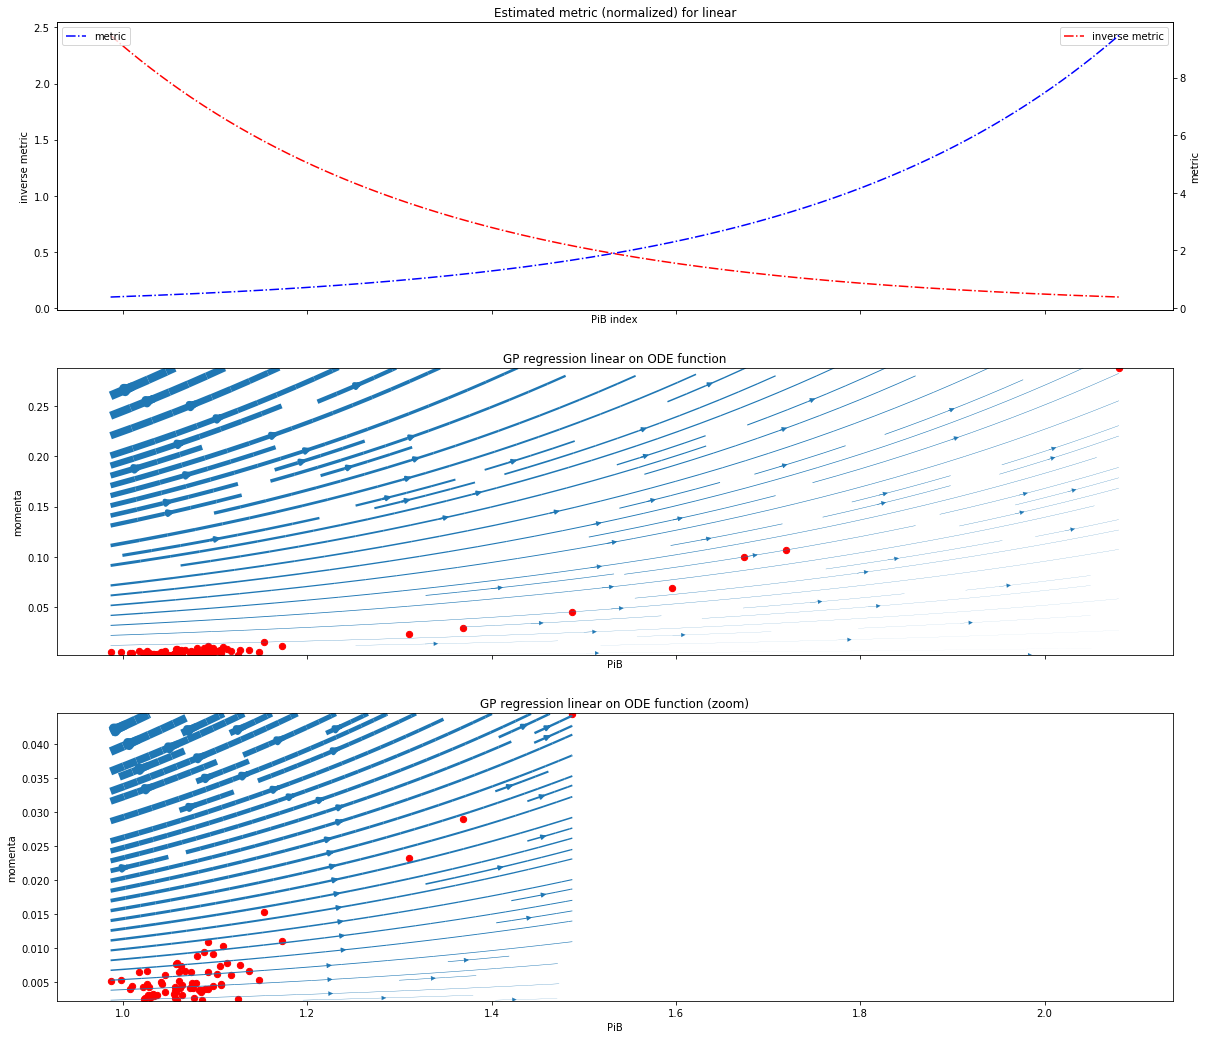

In [9]:
best_HAM_GP = modelGP_HAM_linear     # modelGP_HAM_RBF |  modelGP_HAM_poly2

# -------- Christoffel symbol estimate (trapezoidal integration)
filtered_u_line = np.linspace(filtered_u.min(), filtered_u.max(), 500)
ful_torch = totorch(filtered_u_line, 'float')
Gamma = Christoffel(fitted_model=best_HAM_GP, xmin=ful_torch.min().clone().detach(), xmax=ful_torch.max().clone().detach())

# Hamiltonian object derivation
hamiltonian_fn = Hamiltonian(Gamma)
inverse_estimate = hamiltonian_fn.inversemetric(ful_torch, precision=1000)
metric_estimate = hamiltonian_fn.metric(ful_torch)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 18), sharex=True)
ax1.plot(destandardize_data(torch.from_numpy(filtered_u_line)), np.squeeze(gpu_numpy_detach(inverse_estimate)), '-.r', label='inverse metric')
ax1bis = ax1.twinx()
ax1bis.plot(destandardize_data(torch.from_numpy(filtered_u_line)), np.squeeze(gpu_numpy_detach(metric_estimate)), '-.b', label='metric')
ax1.set_xlabel('PiB index')
ax1.set_ylabel('inverse metric')
ax1bis.set_ylabel('metric')
ax1.set_title('Estimated metric (normalized) for {}'.format(best_HAM_GP.name))
ax1.legend(loc=0)
ax1bis.legend(loc=2)

# -------- associated Hamiltonian
momentum_p = gpu_numpy_detach(hamiltonian_fn.velocity_to_momenta(totorch(filtered_u, 'float'), totorch(v[filtered_index], 'float')))
ax2.scatter(x=destandardize_data(torch.from_numpy(filtered_u)), y=momentum_p, marker='o', color='r', s=40.)
Y, X = np.mgrid[momentum_p.min():momentum_p.max():150j, 
                filtered_u.min():filtered_u.max():150j]
_, X_std = np.mgrid[momentum_p.min():momentum_p.max():150j, 
                    gpu_numpy_detach(destandardize_data(torch.from_numpy(filtered_u))).min():gpu_numpy_detach(destandardize_data(torch.from_numpy(filtered_u))).max():150j]
Z = torch.from_numpy(np.stack([X, Y])).reshape(2, len(X) * len(Y)).t().type(torch.float)
Z.requires_grad = True
Field_grad = hamiltonian_fn.get_Rgrad(Z, retain_graph=False, create_graph=False)
Field_grid = Field_grad.reshape(len(X), len(Y), 2).permute(2, 0, 1)
F_speed = gpu_numpy_detach(torch.norm(Field_grid, p=2, dim=0))
Field_grid = gpu_numpy_detach(Field_grid)
lw = 10 * F_speed / F_speed.max()

#  Varying density along a streamline
strm = ax2.streamplot(X_std, Y, Field_grid[0], Field_grid[1], linewidth=lw, cmap='plasma')
ax2.set_title('Vector field')
ax2.set_ylim(np.min(momentum_p) - 1e-4, np.max(momentum_p) + 1e-4)
ax2.set_xlabel('PiB')
ax2.set_ylabel('momenta')
ax2.set_title('GP regression {} on ODE function'.format(best_HAM_GP.name))

# Zooming on outliers excluded
eps_filter = .05
fIDX = np.where((momentum_p > np.quantile(momentum_p, eps_filter)) & (momentum_p < np.quantile(momentum_p, 1 - eps_filter)))[0]
Y, X = np.mgrid[momentum_p[fIDX].min():momentum_p[fIDX].max():150j, filtered_u[fIDX].min():filtered_u[fIDX].max():150j]
_, X_std = np.mgrid[momentum_p[fIDX].min():momentum_p[fIDX].max():150j, 
                    gpu_numpy_detach(destandardize_data(torch.from_numpy(filtered_u[fIDX]))).min():gpu_numpy_detach(destandardize_data(torch.from_numpy(filtered_u[fIDX]))).max():150j]
Z = torch.from_numpy(np.stack([X, Y])).reshape(2, len(X) * len(Y)).t().type(torch.float)
Z.requires_grad = True
# Hamiltonian integral curves
Field_grad = hamiltonian_fn.get_Rgrad(Z, retain_graph=False, create_graph=False)
Field_grid = Field_grad.reshape(len(X), len(Y), 2).permute(2, 0, 1)
F_speed = gpu_numpy_detach(torch.norm(Field_grid, p=2, dim=0))
Field_grid = gpu_numpy_detach(Field_grid)
lw = 10 * F_speed / F_speed.max()
ax3.scatter(x=destandardize_data(torch.from_numpy(filtered_u[fIDX])), y=momentum_p[fIDX], marker='o', color='r', s=40.)
strm_ = ax3.streamplot(X_std, Y, Field_grid[0], Field_grid[1], linewidth=lw, cmap='plasma')

ax3.set_title('Vector field (zoom)')
ax3.set_ylim(np.min(momentum_p[fIDX]) - 1e-4, np.max(momentum_p[fIDX]) + 1e-4)
ax3.set_xlabel('PiB')
ax3.set_ylabel('momenta')
ax3.set_title('GP regression {} on ODE function (zoom)'.format(best_HAM_GP.name))

plt.show()

Perform **geodesic regression** to estimate initial conditions (gradient descent):
- makes more sense to do it at reference time for everyone directly (instead of optimizing on data and then projecting elsewhere --> compare the perf)
- initialization from Ridge regression estimates

In [10]:
nb_pts = 200
t_obs_var = np.concatenate(t_real).ravel().var()
t_line = np.linspace(np.concatenate(t_real).ravel().min() - 7*t_obs_var, np.concatenate(t_real).ravel().max() + 7*t_obs_var, nb_pts)
x_line = np.linspace(np.concatenate(x_real).ravel().min(), np.concatenate(x_real).ravel().max(), nb_pts)
t_ref = np.mean(t_line)
pib_threshold =(1.2 - data_mean)/ data_std if standardize else torch.Tensor([1.2])

# slightly modifier ivp integrator 
labeler_func = lambda arr: int(np.sum(arr))
y_lab_H = []
initial_conditions = []
tref_initial_conditions = []
time_values = []
data_values = []
rejected_values = []
i_undone = 0
i_total = 0
hamiltonian_fn.require_grad_field(True)


for batch_idx, (positions, maskers, times, sequences, labels) in tqdm(enumerate(all_loader)):
    for i, (position, masker, time, sequence, label) in enumerate(zip(positions, maskers, times, sequences, labels)):
        # ------ get data, estimate roughly position | derivative for initialization of gradient descent at t_bar (resp. t_ref)
        t = gpu_numpy_detach(time[masker == True])
        s = gpu_numpy_detach(sequence[masker == True])
        n = len(t)
        assert n > 2, "At least 3 points required for a 2nd order derivative estimate"
        t_bar = np.mean(t)
        s_bar = np.mean(s)
        do_reg_fit = True
        if do_reg_fit:
            polynomial_features = PolynomialFeatures(degree=2,  include_bias=True)
            alpha_ridge = 1e-10 if standardize else 1e1
            ridge_regression = Ridge(alpha=alpha_ridge, fit_intercept=False)
            t_poly = polynomial_features.fit_transform(t.reshape(-1, 1))
            ridge_regression.fit(t_poly, s)
            theta = np.array(ridge_regression.coef_)
            A_func = lambda t: np.array([[1, t, t**2], [0., 1., 2*t], [0., 0., 2]])
            A_bar = A_func(t_bar)
            sdot_bar = A_bar.dot(theta)[1]  # np.abs() for constraint initialization to be positive velocity
            p_bar = gpu_numpy_detach(hamiltonian_fn.velocity_to_momenta(q=torch.from_numpy(np.array(A_bar.dot(theta)[0])).view(-1,1), v=torch.from_numpy(np.array(sdot_bar)).view(-1,1)))
        else:
            p_bar = 1.
        # ------ Geodesic regression of initial constraints via Gradient Descent steps (differentiability of overall)
        lr = 1e-1
        min_lr = 1e-5
        lr_decay = .9
        patience = 5
        initial_condition = torch.Tensor([s_bar, p_bar]).view(1, -1)     # (batch, 2*dim)
        torch_t_eval = torch.from_numpy(t)
        torch_y = torch.from_numpy(s)
        torch_t_eval.requires_grad = False
        torch_y.requires_grad = False
        optimizer = Adam([initial_condition], lr=lr, amsgrad=True)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_decay, patience=patience, 
                                      min_lr=min_lr, verbose=False, threshold_mode='abs')

        # Optimize
        epochs = 100
        loss_ = 0
        initial_condition.requires_grad = True
        print('IC before optimization', initial_condition)
        regressed_flow = 0
        best_loss_ = np.inf
        for epoch in range(epochs):
            optimizer.zero_grad()
            # ----- Linear regression with pseudo inverse
            regressed_flow = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=torch_t_eval, y0=initial_condition, 
                                                          method='midpoint', adjoint_boolean=False, create_graph=True, retain_graph=True)
            delta = regressed_flow.squeeze()[:,0] - torch_y
            loss_ = torch.mean(delta**2, dim=0, keepdim=False)
            loss_.backward(retain_graph=True)
            optimizer.step()
            scheduler.step(loss_)
            # Check NaN
            if gpu_numpy_detach(torch.isnan(initial_condition).sum()):
                # print(epoch, initial_condition)
                print('Nan encountered : breaking loop at epoch {}'.format(epoch))
                break
            
            # Retrieve best regression parameters
            if gpu_numpy_detach(loss_) < best_loss_:
                best_loss_ = gpu_numpy_detach(loss_)
                best_init_ = gpu_numpy_detach(initial_condition)

        # ------ From previous computation, estimate geodesic by **shooting** from previous initial conditions to real observations
        t_evaluator = torch.from_numpy(np.array([t[0], t_ref]))
        best_y0s = torch.from_numpy(best_init_)
        best_y0s.requires_grad = True
        tref_regressed_flow = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=t_evaluator, y0=best_y0s, 
                                                           method='midpoint', adjoint_boolean=False, create_graph=True, retain_graph=False)
        tref_initial_conditions.append(gpu_numpy_detach(tref_regressed_flow[-1]))
        initial_conditions.append(best_init_)
        time_values.append(t)
        data_values.append(s)
        y_lab_H.append(labeler_func(gpu_numpy_detach(label)))
        i_total += 1
print('>> Rejected rate = {:.1f}% ({} / {})\n'.format(100 * (i_undone / float(i_total)), i_undone, i_total))

idxH_33 = np.argwhere(np.array(y_lab_H) == 6)
idxH_34 = np.argwhere(np.array(y_lab_H) == 7)
idxH_44 = np.argwhere(np.array(y_lab_H) == 8)

np_ic = np.concatenate([ic.reshape(-1, 1) for ic in initial_conditions], axis=-1)
np_ic_ref = np.concatenate([ic.reshape(-1, 1) for ic in tref_initial_conditions], axis=-1)

0it [00:00, ?it/s]

IC before optimization tensor([[1.3125, 0.0233]], requires_grad=True)
IC before optimization tensor([[1.1116, 0.0145]], requires_grad=True)
IC before optimization tensor([[ 1.0966, -0.0014]], requires_grad=True)
IC before optimization tensor([[1.0231, 0.0042]], requires_grad=True)
IC before optimization tensor([[1.1745, 0.0111]], requires_grad=True)
IC before optimization tensor([[1.0600, 0.0077]], requires_grad=True)
IC before optimization tensor([[1.5354, 0.0680]], requires_grad=True)
IC before optimization tensor([[1.0507e+00, 5.0732e-04]], requires_grad=True)
IC before optimization tensor([[ 1.1003e+00, -5.7474e-05]], requires_grad=True)
IC before optimization tensor([[1.2409, 0.0249]], requires_grad=True)
IC before optimization tensor([[1.0761, 0.0048]], requires_grad=True)
IC before optimization tensor([[1.4636, 0.0601]], requires_grad=True)
IC before optimization tensor([[1.0772, 0.0040]], requires_grad=True)
IC before optimization tensor([[1.1654, 0.0020]], requires_grad=True)


1it [00:51, 51.47s/it]

IC before optimization tensor([[1.1034, 0.0062]], requires_grad=True)
IC before optimization tensor([[1.0352, 0.0029]], requires_grad=True)
IC before optimization tensor([[1.0291e+00, 1.9753e-04]], requires_grad=True)
IC before optimization tensor([[1.0760, 0.0065]], requires_grad=True)
IC before optimization tensor([[1.0573, 0.0017]], requires_grad=True)
IC before optimization tensor([[1.0596, 0.0023]], requires_grad=True)
IC before optimization tensor([[1.1187, 0.0060]], requires_grad=True)
IC before optimization tensor([[1.0740, 0.0040]], requires_grad=True)
IC before optimization tensor([[1.5985, 0.0685]], requires_grad=True)
IC before optimization tensor([[1.0484, 0.0060]], requires_grad=True)
IC before optimization tensor([[1.2304, 0.0231]], requires_grad=True)
IC before optimization tensor([[1.0620, 0.0065]], requires_grad=True)
IC before optimization tensor([[1.0862, 0.0035]], requires_grad=True)
IC before optimization tensor([[1.0584, 0.0043]], requires_grad=True)
IC before op

2it [01:45, 52.33s/it]

IC before optimization tensor([[1.0940, 0.0108]], requires_grad=True)
IC before optimization tensor([[0.9979, 0.0018]], requires_grad=True)
IC before optimization tensor([[1.0378e+00, 4.6253e-04]], requires_grad=True)
IC before optimization tensor([[1.0392, 0.0031]], requires_grad=True)
IC before optimization tensor([[1.0783, 0.0027]], requires_grad=True)
IC before optimization tensor([[1.4133, 0.0543]], requires_grad=True)
IC before optimization tensor([[1.0197, 0.0014]], requires_grad=True)
IC before optimization tensor([[1.1565, 0.0136]], requires_grad=True)
IC before optimization tensor([[1.1081, 0.0047]], requires_grad=True)
IC before optimization tensor([[1.1494, 0.0053]], requires_grad=True)
IC before optimization tensor([[1.0282, 0.0031]], requires_grad=True)
IC before optimization tensor([[1.1601, 0.0144]], requires_grad=True)
IC before optimization tensor([[1.0949, 0.0064]], requires_grad=True)
IC before optimization tensor([[1.0856e+00, 1.0254e-03]], requires_grad=True)
IC b

3it [02:40, 53.05s/it]

IC before optimization tensor([[1.0684, 0.0066]], requires_grad=True)
IC before optimization tensor([[1.7062, 0.1240]], requires_grad=True)
IC before optimization tensor([[1.0900e+00, 9.0916e-04]], requires_grad=True)
IC before optimization tensor([[1.0273, 0.0048]], requires_grad=True)
IC before optimization tensor([[1.2210, 0.0220]], requires_grad=True)
IC before optimization tensor([[1.6762, 0.0997]], requires_grad=True)
IC before optimization tensor([[1.0620, 0.0052]], requires_grad=True)
IC before optimization tensor([[1.4901, 0.0445]], requires_grad=True)
IC before optimization tensor([[1.0994, 0.0044]], requires_grad=True)
IC before optimization tensor([[1.2537, 0.0242]], requires_grad=True)
IC before optimization tensor([[1.0498, 0.0019]], requires_grad=True)
IC before optimization tensor([[1.0584, 0.0036]], requires_grad=True)
IC before optimization tensor([[1.0313, 0.0015]], requires_grad=True)
IC before optimization tensor([[1.0297, 0.0043]], requires_grad=True)
IC before op

4it [03:31, 52.56s/it]

IC before optimization tensor([[1.1151, 0.0079]], requires_grad=True)
IC before optimization tensor([[1.0933, 0.0040]], requires_grad=True)
IC before optimization tensor([[1.0571, 0.0032]], requires_grad=True)
IC before optimization tensor([[1.0587, 0.0077]], requires_grad=True)
IC before optimization tensor([[1.1075, 0.0045]], requires_grad=True)
IC before optimization tensor([[1.0319, 0.0031]], requires_grad=True)
IC before optimization tensor([[ 1.0477e+00, -3.7628e-06]], requires_grad=True)
IC before optimization tensor([[1.0300, 0.0027]], requires_grad=True)
IC before optimization tensor([[1.0906, 0.0040]], requires_grad=True)
IC before optimization tensor([[2.0825, 0.2882]], requires_grad=True)
IC before optimization tensor([[1.1269, 0.0025]], requires_grad=True)
IC before optimization tensor([[1.3710, 0.0289]], requires_grad=True)
IC before optimization tensor([[1.1559, 0.0152]], requires_grad=True)
IC before optimization tensor([[1.0701, 0.0018]], requires_grad=True)
IC before 

5it [04:22, 51.82s/it]

IC before optimization tensor([[1.1003, 0.0091]], requires_grad=True)
IC before optimization tensor([[1.0312, 0.0030]], requires_grad=True)
IC before optimization tensor([[1.0579, 0.0026]], requires_grad=True)
IC before optimization tensor([[1.0835, 0.0038]], requires_grad=True)
IC before optimization tensor([[1.0871, 0.0023]], requires_grad=True)
IC before optimization tensor([[1.0506, 0.0012]], requires_grad=True)
IC before optimization tensor([[1.0585, 0.0036]], requires_grad=True)
IC before optimization tensor([[1.0335, 0.0031]], requires_grad=True)
IC before optimization tensor([[1.0085, 0.0039]], requires_grad=True)
IC before optimization tensor([[1.0282, 0.0066]], requires_grad=True)
IC before optimization tensor([[1.0657, 0.0031]], requires_grad=True)
IC before optimization tensor([[1.4188, 0.0473]], requires_grad=True)
IC before optimization tensor([[1.0194, 0.0064]], requires_grad=True)
IC before optimization tensor([[1.0649, 0.0073]], requires_grad=True)
IC before optimizati

6it [05:13, 51.61s/it]

IC before optimization tensor([[1.0310, 0.0011]], requires_grad=True)
IC before optimization tensor([[1.1378, 0.0066]], requires_grad=True)
IC before optimization tensor([[1.0513, 0.0020]], requires_grad=True)
IC before optimization tensor([[1.0896, 0.0022]], requires_grad=True)
IC before optimization tensor([[1.1107, 0.0103]], requires_grad=True)
IC before optimization tensor([[1.0895, 0.0094]], requires_grad=True)
IC before optimization tensor([[0.9887, 0.0051]], requires_grad=True)
IC before optimization tensor([[1.0255, 0.0026]], requires_grad=True)
IC before optimization tensor([[1.2219, 0.0233]], requires_grad=True)
IC before optimization tensor([[1.1077, 0.0073]], requires_grad=True)
IC before optimization tensor([[1.1281, 0.0074]], requires_grad=True)
IC before optimization tensor([[1.0651, 0.0045]], requires_grad=True)
IC before optimization tensor([[1.0635, 0.0041]], requires_grad=True)
IC before optimization tensor([[1.0980e+00, 9.8237e-04]], requires_grad=True)
IC before op

7it [06:01, 50.75s/it]

IC before optimization tensor([[1.4546, 0.0422]], requires_grad=True)


8it [06:04, 45.62s/it]

>> Rejected rate = 0.0% (0 / 113)



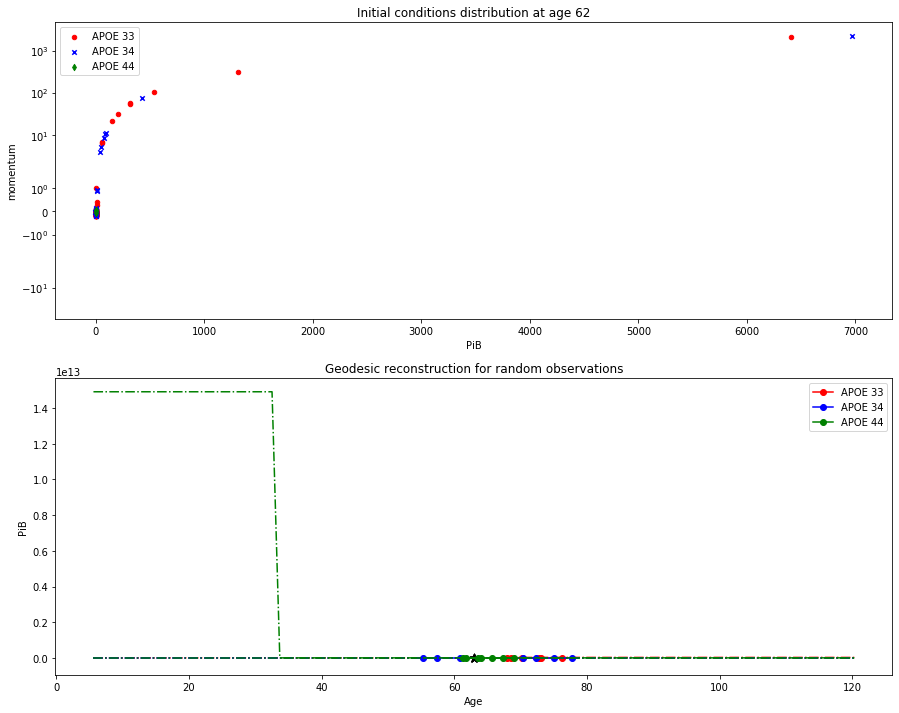

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
# Initial conditions regression at reference age
ax1.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_33])), y=np_ic_ref[1, idxH_33], marker='o', color='r', s=20., label='APOE 33')
ax1.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_34])), y=np_ic_ref[1, idxH_34], marker='x', color='b', s=20., label='APOE 34')
ax1.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_44])), y=np_ic_ref[1, idxH_44], marker='d', color='g', s=20., label='APOE 44')
ax1.set_xlabel('PiB')
ax1.set_ylabel('momentum')
ax1.set_yscale('symlog')
ax1.set_title('Initial conditions distribution at age {:d}'.format(int(destandardize_time(torch.from_numpy(np.array(t_ref))))))
ax1.legend()

# print(np_ic.min(), np_ic.max())
# print(np_ic_ref.min(), np_ic_ref.max())

# corresponding random geodesics
idx1, idx2, idx3 = np.random.choice(idxH_33.squeeze(), 2, replace=False), np.random.choice(idxH_34.squeeze(), 2, replace=False), np.random.choice(idxH_44.squeeze(), 2, replace=False)
for idds, name, color in zip([idx1, idx2, idx3], ['APOE 33', 'APOE 34', 'APOE 44'], ['r', 'b', 'g']):
    for i, idd in enumerate(idds):
        idd = int(idd)
        # real observed data
        if i == 0:
            ax2.plot(destandardize_time(torch.from_numpy(time_values[idd])), destandardize_data(torch.from_numpy(data_values[idd])), 
                     linestyle='-', marker='o', color=color, label=name)
        else:
            ax2.plot(destandardize_time(torch.from_numpy(time_values[idd])), destandardize_data(torch.from_numpy(data_values[idd])), 
                     linestyle='-', marker='o', color=color)
        ax2.scatter(x=destandardize_time(torch.from_numpy(np.array([t_ref]))), y=destandardize_data(torch.from_numpy(np_ic_ref)[0, idd]), 
                    marker='*', s=75, color='k')
        # Compute real geodesic onward and backward of reference age
        t_backward = torch.linspace(t_ref, np.concatenate(t_real).ravel().min() - 1*t_obs_var, 50)
        t_forward = torch.linspace(t_ref, np.concatenate(t_real).ravel().max() + 1*t_obs_var,  50)
        t_all = np.concatenate((gpu_numpy_detach(t_backward)[::-1][:-1], gpu_numpy_detach(t_forward)))
        best_y0s = torch.from_numpy(np_ic_ref[:, idd]).view(1, -1)
        best_y0s.requires_grad = True
        forward_geo = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=t_forward, y0=best_y0s, 
                                                   method='midpoint', adjoint_boolean=False, create_graph=False, retain_graph=False)
        backward_geo = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=t_backward, y0=best_y0s, 
                                                    method='midpoint', adjoint_boolean=False, create_graph=False, retain_graph=False)
        all_geo = np.concatenate((gpu_numpy_detach(backward_geo)[::-1][:-1,0,0], gpu_numpy_detach(forward_geo)[:,0,0]))
        ax2.plot(destandardize_time(torch.from_numpy(t_all)), destandardize_data(torch.from_numpy(all_geo)), linestyle='-.', color=color)
ax2.set_xlabel('Age')
ax2.set_ylabel('PiB')
ax2.set_title('Geodesic reconstruction for random observations')
ax2.legend()
plt.show()

Back to previous plots, with this time the initial conditions estimated at reference age (via geodesic regression)

KeyboardInterrupt: 

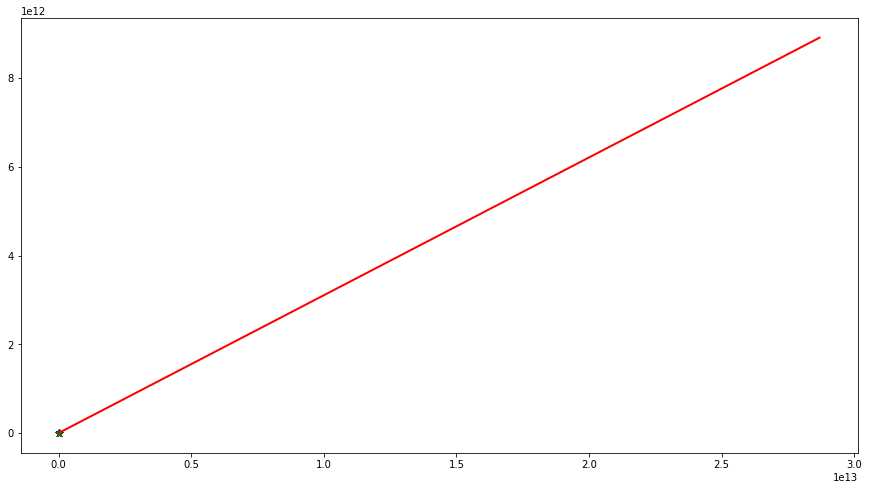

In [12]:
# -------- STATIC VERSION (at reference age with geodesic interpolation)
fig, ax = plt.subplots(figsize=(15, 8))

# initial conditions distirbutions
ax.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_33])), y=np_ic_ref[1, idxH_33], marker='*', color='r', s=50., label='APOE 33')
ax.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_34])), y=np_ic_ref[1, idxH_34], marker='*', color='b', s=50., label='APOE 34')
ax.scatter(x=destandardize_data(torch.from_numpy(np_ic_ref[0, idxH_44])), y=np_ic_ref[1, idxH_44], marker='*', color='g', s=50., label='APOE 44')

# Reconstructed trajectories | estimated age at onset (aka PiB positivity)
pib_at_t_ref = []   # storing estimated age of crossing PiB positivity --> some individuals SHOULD NOT be registered, here we do NOT have isotonic property
for idds, name, color in zip([idxH_33.squeeze(), idxH_34.squeeze(), idxH_44.squeeze()], ['APOE 33', 'APOE 34', 'APOE 44'], ['r', 'b', 'g']):
    for i, idd in enumerate(idds):
        idd = int(idd)
        # Time stretch : intrapolation | extrapolation
        t_obs_min, t_obs_max = time_values[idd][0], time_values[idd][-1]
        t_backward = torch.linspace(t_ref, np.concatenate(t_real).ravel().min() - 2*t_obs_var, 50)
        t_forward = torch.linspace(t_ref, np.concatenate(t_real).ravel().max() + 2*t_obs_var,  50)
        t_all = np.concatenate((gpu_numpy_detach(t_backward)[::-1][:-1], gpu_numpy_detach(t_forward)))
        intrapolation_indexes = (t_all > t_obs_min) & (t_all < t_obs_max)
        
        best_y0s = torch.from_numpy(np_ic_ref[:, idd]).view(1, -1)
        best_y0s.requires_grad = True
        forward_geo = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=t_forward, y0=best_y0s, 
                                                   method='midpoint', adjoint_boolean=False, create_graph=True, retain_graph=False)
        backward_geo = torchdiffeq_torch_integrator(GP_model=best_HAM_GP, t_eval=t_backward, y0=best_y0s, 
                                                    method='midpoint', adjoint_boolean=False, create_graph=True, retain_graph=False)
        all_geo = np.concatenate((gpu_numpy_detach(backward_geo)[::-1][:-1,0,:], gpu_numpy_detach(forward_geo)[:,0,:]), axis=0)
        
        # Plot trajectories in phase space | emphasis on observed time sequence
        ax.plot(destandardize_data(torch.from_numpy(all_geo[:, 0])), all_geo[:, 1], linestyle='-.', linewidth=.5, color=color)
        ax.plot(destandardize_data(torch.from_numpy(all_geo[intrapolation_indexes, 0])), all_geo[intrapolation_indexes, 1], linestyle='-', linewidth=2., color=color)
        posidx = np.where(all_geo[:, 0] > gpu_numpy_detach(pib_threshold))[0]
        pib_at_t_ref.append(t_all[posidx[0]] if len(posidx) else None)

ax.set_xlabel('PiB')
ax.set_xlim(0.5, 2.5)
ax.set_ylabel('momentum')
ax.set_yscale('symlog')
ax.set_title('Phase space trajectories from reference age {:d}'.format(int(destandardize_time(torch.from_numpy(np.array(t_ref))))))
ax.legend()

Wilcoxon unpaired test on initial conditions (separate, or as pair) :

In [ ]:
# -------- randomly draw pairs between labels
boxplot_stock1 = []
boxplot_stock2 = []
for i_, name in zip([idxH_33, idxH_34, idxH_44], ['APOE 33', 'APOE 34', 'APOE 44']):
    age_tref = int(gpu_numpy_detach(destandardize_time(torch.from_numpy(np.array([t_ref]))))[0])
    pib_tref = gpu_numpy_detach(destandardize_data(torch.from_numpy(np_ic_ref[0, i_])))
    acc_tref = gpu_numpy_detach(destandardize_data(torch.from_numpy(np_ic_ref[1, i_])))
    # trueage_tref = int(gpu_numpy_detach(np.array([pib_at_t_ref[int(i)] for i in i_])))
    boxplot_stock1.append(pib_tref)
    # boxplot_stock2.append(trueage_tref)
    print('{}'.format(name))
    print('          PiB at reference age {} : {:.2f} +- {:.2f}'.format(age_tref, np.mean(pib_tref), np.std(pib_tref)))
    print('          Acc at reference age {} : {:.2f} +- {:.2f}'.format(age_tref, np.mean(acc_tref), np.std(acc_tref)))

# -------- compute wilcowon vectorial scores
wilcox_A_01 = ranksums(x=np_ic[0, idx_33].squeeze(), 
                         y=np_ic[0, idx_34].squeeze())
wilcox_A_02 = ranksums(x=np_ic[0, idx_33].squeeze(), 
                         y=np_ic[0, idx_44].squeeze())
wilcox_A_12 = ranksums(x=np_ic[0, idx_34].squeeze(), 
                         y=np_ic[0, idx_44].squeeze())
wilcox_B_01 = ranksums(x=np_ic[1, idx_33].squeeze(), 
                         y=np_ic[1, idx_34].squeeze())
wilcox_B_02 = ranksums(x=np_ic[1, idx_33].squeeze(), 
                         y=np_ic[1, idx_44].squeeze())
wilcox_B_12 = ranksums(x=np_ic[1, idx_34].squeeze(), 
                         y=np_ic[1, idx_44].squeeze())

print('\n')
print('Wilcoxon test p-value for difference in PIB (at ref age) between {} and {} = {:.3f}'.format('APOE 33', 'APOE 34', wilcox_A_01.pvalue))
print('Wilcoxon test p-value for difference in vel (at ref age) between {} and {} = {:.3f}'.format('APOE 33', 'APOE 34', wilcox_B_01.pvalue))
print('-----')
print('Wilcoxon test p-value for difference in age at PIB positive between {} and {} = {:.3f}'.format('APOE 33', 'APOE 44', wilcox_A_02.pvalue))
print('Wilcoxon test p-value for difference in vel (at ref age) between {} and {} = {:.3f}'.format('APOE 33', 'APOE 44', wilcox_B_02.pvalue))
print('-----')
print('Wilcoxon test p-value for difference in age at PIB positive between {} and {} = {:.3f}'.format('APOE 34', 'APOE 44', wilcox_A_12.pvalue))
print('Wilcoxon test p-value for difference in vel (at ref age) between {} and {} = {:.3f}'.format('APOE 34', 'APOE 44', wilcox_B_12.pvalue))
print('\n')

fig = plt.subplots(figsize=(10, 5))
plt.boxplot(boxplot_stock1)
plt.xticks([i for i in range(1, 4)], ['APOE 33', 'APOE 34', 'APOE 44'], rotation=60)
plt.ylabel('PiB')
plt.title('PiB score at reference age : {} years'.format(age_tref))
plt.show()